# Numerical Simulation of a Galactic Dynamo

Mean field induction equation is given by $$\frac{\partial \overline{\boldsymbol{B}}}{\partial t}=\nabla \times(\overline{\boldsymbol{V}} \times \overline{\boldsymbol{B}}+\mathcal{E}-\eta \nabla \times \overline{\boldsymbol{B}})$$. Here $\overline{B}$, $\overline{V}$, $\mathcal{E}$($\equiv \overline{\boldsymbol{v} \times \boldsymbol{b}}$ ) and $\eta$ are representation ofmean magnetic field, mean velocity field, mean electromotive force and magnetic diffusivity, respectively.



 If we assume $\mathcal{E}=\alpha \overline{\boldsymbol{B}}-\eta_{\mathrm{t}} \boldsymbol{\nabla} \times \overline{\boldsymbol{B}}$ and to solve the equations in cylindrical coordinates (r, $\phi$, $z$), we make the approximations by ignoring the term $(\overline{\boldsymbol{V}} \times \overline{\boldsymbol{B}})$ and $\alpha \overline{\boldsymbol{B}}$ terms.


Therefore, we have
$$\frac{\partial \overline{\boldsymbol{B}}}{\partial t}=-\nabla \times \left( \eta_T (\nabla \times \overline{\boldsymbol{B}})\right)$$
If we assume $\eta_T$ is a constant in time. The RHS of above eqaution simplifies to $\nabla \times(\nabla \times \overline{\mathbf{B}})$. After which we can apply the vector theorem $$\nabla \times(\nabla \times \overline{\mathbf{B}})=\nabla(\nabla \cdot \overline{\mathbf{B}})-\nabla^2 \overline{\mathbf{B}}$$


Therefore, the final expression becomes
$$\frac{\partial \overline{\boldsymbol{B}}}{\partial t}=\eta_T \nabla^2 \overline{\mathbf{B}}$$


This is the diffusion equation and can be solved using a variety of methods. Crank-Nicolson method is implemented in this project. 

## Crank-Nicolson Method


The Crank-Nicolson method is a numerical technique used for solving partial differential equations, particularly for parabolic equations. It's a finite difference method that combines implicit and explicit time-stepping schemes to achieve a second-order accuracy in time.

### Basic Idea
The method is based on the central difference approximation for the spatial derivative and a combination of backward Euler and forward Euler methods for the time derivative. By averaging the solutions at two adjacent time steps, Crank-Nicolson method provides a more stable and accurate solution compared to fully implicit or explicit methods.


For Crank-Nicolson method, we can write $u_t$, $u_{xx}$ and $u_x$ as:
$$u_t = \frac{u_{i,j+1}-u_{i,j}}{\Delta t}$$
$$u_{xx} = \frac{1}{2(\Delta x)^2} [(u_{i+1,j+1} -2u_{i,j+1} + u_{i-1,j+1})+ (u_{i+1,j}-2u_{i,j}+u_{i-1,j})]$$
Substituting this in he heat equation $u_{xx}$ = $u_t$ along with backward discretised $u_t$ gives us
$$\frac{u_{i,j}-u_{i-1,j}}{\Delta t}=\frac{1}{2\Delta x^2}[(u_{i+1,j+1} -2u_{i,j+1} + u_{i-1,j+1})+ (u_{i+1,j}-2u_{i,j}+u_{i-1,j})]$$
$$-\alpha (u_{i+1,j}+u_{i-1,j})+2(1+\alpha )u_{i,j}=\alpha(u_{i+1,j-1}+u_{i-1,j-1})+2(1-\alpha )u_{i,j-1}$$

$$\implies (2\mathbb{I}+\alpha \mathbf{B}) V_j=(2\mathbb{I}-\alpha \mathbf{B}) V_{j-1} $$
$$ V j=(2\mathbb{I}+\alpha\mathbf{B})^{-1}(2\mathbb{I}-\alpha\mathbf{B}) V_{j-1}
$$

where
$$\mathbf{B}=\left(\begin{array}{rrrrr}
2 & -1 & 0 & 0 & \cdots \\
-1 & 2 & -1 & 0 & \cdots \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
0 & \cdots & 0 & -1 & 2
\end{array}\right)$$
$$\alpha=\frac{\Delta t}{2\Delta x^2}$$


### Algorithm
The Crank-Nicolson algorithm can be summarized in the following steps:

1. Discretization: Discretize the spatial domain and time domain.
2. Initialization: Set the initial conditions.
3. Iteration:Calculate the right-hand side of the equation using the values at the current time step and the previous time step. Solve the resulting system of equations.
4. Repeat: Iterate until reaching the desired final time.

#### Advantages
* Stability: The method is unconditionally stable for linear problems.
* Accuracy: Offers second-order accuracy in time.
* Efficiency: It can be more computationally efficient compared to fully implicit methods such as Euler and Predictor corrector.
#### Limitations
- Complexity: The need to solve a system of equations at each time step can increase computational complexity, especially for large systems.


In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


In [2]:

# Parameters
eta = 1e-2   # Magnetic diffusivity
L = 1.0      # Length of the domain
T = 5.0      # Total time
Nx = 200   # Number of spatial grid points
Nt = 1000    # Number of time steps

def initial_condition(x):
    return 50000 * np.sin(np.pi *(x+1)/2)
def boundary_conditions(B):
    B[0] = 0
    B[-1] = 0
def create_A(r, Nx):
    A = np.zeros((Nx - 1, Nx - 1))
    for i in range(Nx - 1):
        A[i, i] = 1 + 2 * r
        if i > 0:
            A[i, i - 1] = -r
        if i < Nx - 2:
            A[i, i + 1] = -r
    return A
def create_B_matrix(r, Nx):
    B_matrix = np.zeros((Nx - 1, Nx - 1))
    for i in range(Nx - 1):
        B_matrix[i, i] = 1 - 2 * r
        if i > 0:
            B_matrix[i, i - 1] = r
        if i < Nx - 2:
            B_matrix[i, i + 1] = r
    return B_matrix
def crank_nicolson_magnetic_diffusion(x,t,eta, Nx, Nt, L, T,initial,boundary):
    dx = L / Nx
    dt = T / Nt
    r = eta * dt / (2 * dx**2)
    B = np.zeros((Nx+1, Nt+1))
    B[:, 0] = initial(x)
    A =create_A(r,Nx) 
    B_matrix = create_B_matrix(r,Nx)
    for j in range(Nt):
        boundary(B[:, j])
        B[1:-1, j+1] = np.linalg.solve(A, np.dot(B_matrix, B[1:-1, j]))
    return B



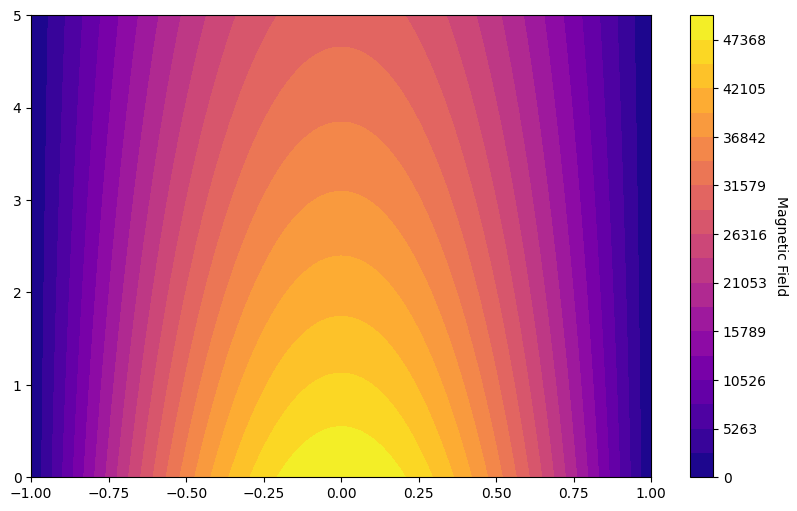

In [3]:
def calculate_B_i(eta,Nx,Nt,L,T,method=crank_nicolson_magnetic_diffusion,initial=initial_condition,boundary=boundary_conditions):
    # Grid
    x = np.linspace(-1, 1, Nx+1)  # Normalized spatial grid
    t = np.linspace(0, T, Nt+1)    # Time grid
    dx = x[1] - x[0]
    dt = t[1] - t[0]
    # Solve magnetic field diffusion equation using Crank-Nicolson method
    magnetic_field = method(x,t,eta, Nx, Nt, L, T,initial,boundary)

    # Contour 
    plt.figure(figsize=(10, 6))
    levels = np.linspace(np.min(magnetic_field), np.max(magnetic_field), 20)
    plt.contourf(x, t, magnetic_field.T, levels=levels, cmap='plasma')
    cbar = plt.colorbar(label='Magnetic Field')
    cbar.set_label('Magnetic Field', rotation=270, labelpad=15)
    plt.show()
    return magnetic_field
B_z=calculate_B_i(eta,Nx,Nt,L,T)

Gamma from fit: -0.09869401667429793
Gamma from thrids: -0.09869401667429788


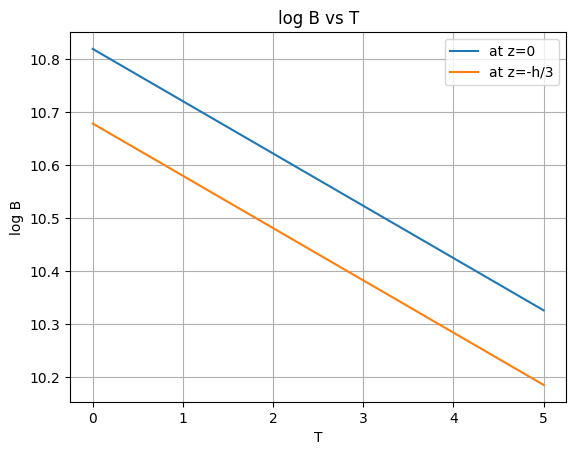

In [4]:

B=B_z
middle_index = len(B) // 2
thirds=len(B)//3
B_middle = B[middle_index, :]
B_thirds = B[thirds, :]
def exponential_func(t, B0, gamma):
    return B0 * np.exp(gamma * t)
t_fit = np.linspace(0, T, Nt+1)  
popt, pcov = curve_fit(exponential_func, t_fit, B_middle)
popt1, pcov1 = curve_fit(exponential_func, t_fit, B_thirds)
gamma_optimal = popt[1]#popt[B_0,gamma]
print("Gamma from fit:", gamma_optimal)
print("Gamma from thrids:", popt1[1])
log_B = np.log(B_middle)
log_B1 = np.log(B_thirds)
plt.plot(t_fit,log_B,label="at z=0")
plt.plot(t_fit,log_B1,label="at z=-h/3")

plt.ylabel("log B")
plt.xlabel("T")
plt.title("log B vs T")
plt.grid()
plt.legend()
plt.show()

In [5]:
def initial_condition(x):
    return 50000 * np.sin(np.pi *(x+1)/2)

**Br and Bphi**

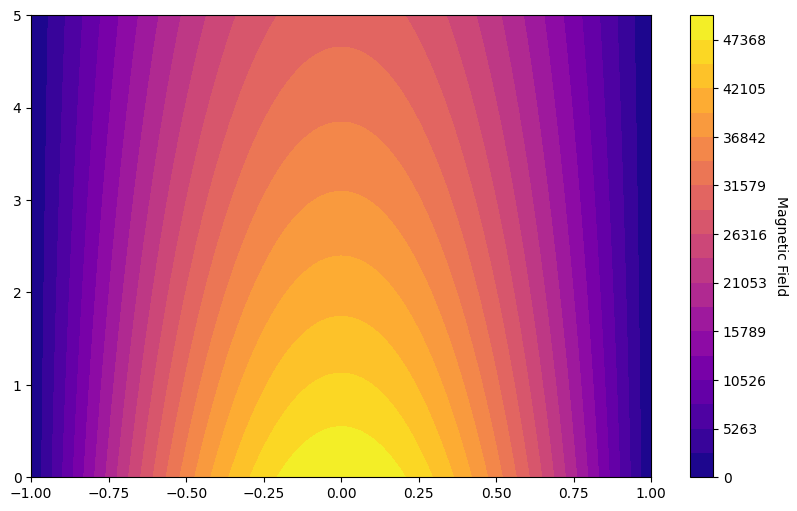

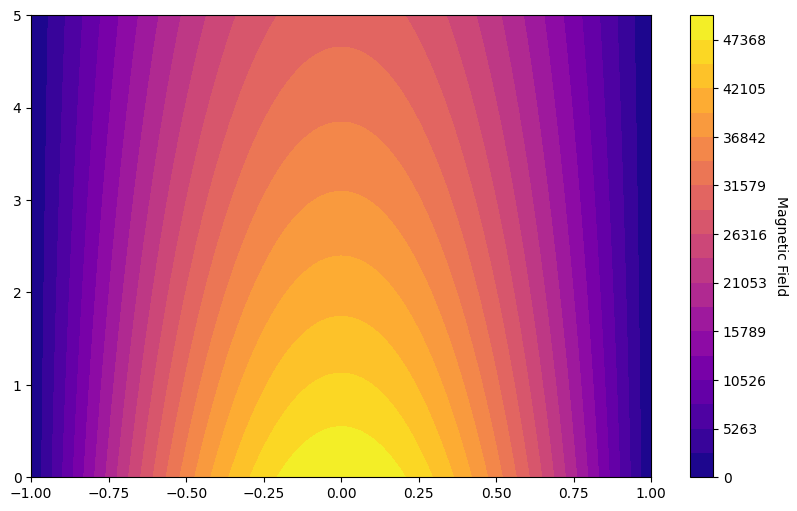

In [6]:
B_r=calculate_B_i(eta,Nx,Nt,L,T)
B_phi=calculate_B_i(eta,Nx,Nt,L,T)

In [7]:
def get_mean_field_B(B_i):
    meanB_t=[]
    for i in range(0,len(B_i)):
        meanB_t.append(np.mean(B[:,i]))
    return meanB_t
MeanBR=get_mean_field_B(B_r)
MeanBPhi=get_mean_field_B(B_phi)
print("MeanBR:",MeanBR)
print("MeanBPhi:",MeanBPhi)

MeanBR: [31671.974245988098, 31656.348929846503, 31640.731322428794, 31625.121419931886, 31609.51921855458, 31593.92471449753, 31578.337903963282, 31562.758783156245, 31547.187348282707, 31531.623595550824, 31516.067521170626, 31500.519121354006, 31484.97839231474, 31469.44533026845, 31453.91993143265, 31438.402192026704, 31422.89210827184, 31407.38967639116, 31391.894892609627, 31376.407753154057, 31360.928254253133, 31345.456392137414, 31329.99216303929, 31314.53556319303, 31299.08658883476, 31283.645236202447, 31268.21150153593, 31252.785381076905, 31237.36687106891, 31221.955967757338, 31206.55266738944, 31191.156966214323, 31175.768860482927, 31160.388346448053, 31145.015420364365, 31129.65007848834, 31114.292317078336, 31098.94213239454, 31083.599520698986, 31068.264478255544, 31052.937001329945, 31037.61708618976, 31022.304729104377, 31006.999926345048, 30991.702674184864, 30976.412968898752, 30961.130806763467, 30945.856184057615, 30930.589097061616, 30915.329542057763, 30900.0

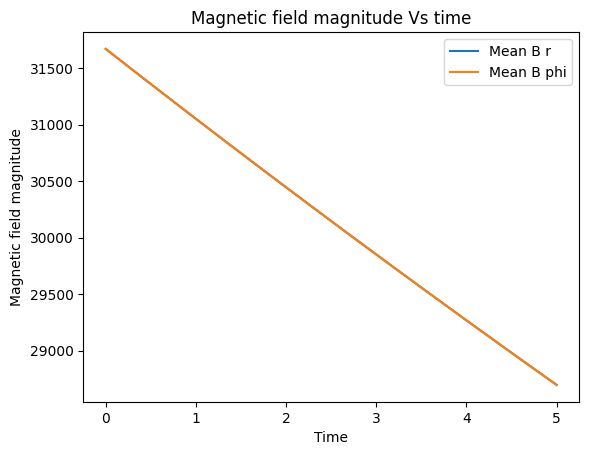

In [8]:
t_fit = np.linspace(0, T, len(MeanBPhi))  
plt.plot(t_fit,MeanBR,label="Mean B r")
plt.plot(t_fit,MeanBPhi,label="Mean B phi")
plt.ylabel("Magnetic field magnitude")
plt.xlabel("Time")

plt.title("Magnetic field magnitude Vs time")
plt.legend()
plt.show()

In [9]:
def get_pitch(MeanBR,MeanBPhi):
    pitchvalues=[]
    for i in range(0,len(MeanBR)):
        pitchvalues.append(math.atan(MeanBR[i]/MeanBPhi[i]))
    return pitchvalues
PitchVTime=get_pitch(MeanBR,MeanBPhi)

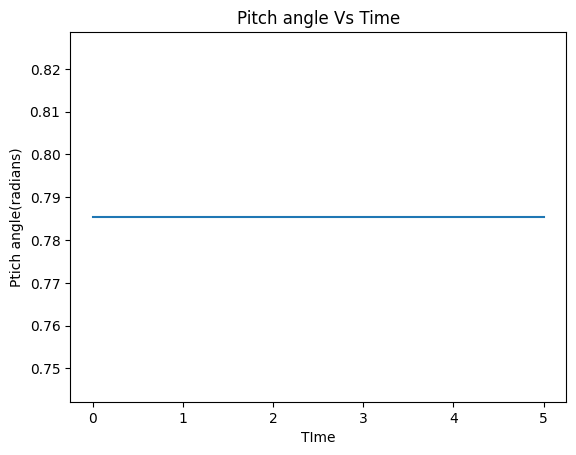

In [10]:
plt.plot(t_fit,PitchVTime)
plt.ylabel("Ptich angle(radians)")
plt.xlabel("TIme")
plt.title("Pitch angle Vs Time")
plt.show()

**Different seed functions**

In [11]:
def three_peak_initial(x,amp=50000):
    peak1 = np.exp(-(x  / 0.1) ** 2)  # Peak at x = 0
    peak2 = np.exp(-((x + 0.3) / 0.1) ** 2)  # Peak at x = -0.3
    peak3 = np.exp(-((x - 0.3) / 0.1) ** 2)  # Peak at x = 0.3
    return amp*(1 * peak1 + 0.4 * peak2 + 0.4 * peak3)
def one_peak_initial(x,amp=50000):
    peak1 = np.exp(-(x  / 0.1) ** 2)     
    return amp*(peak1)

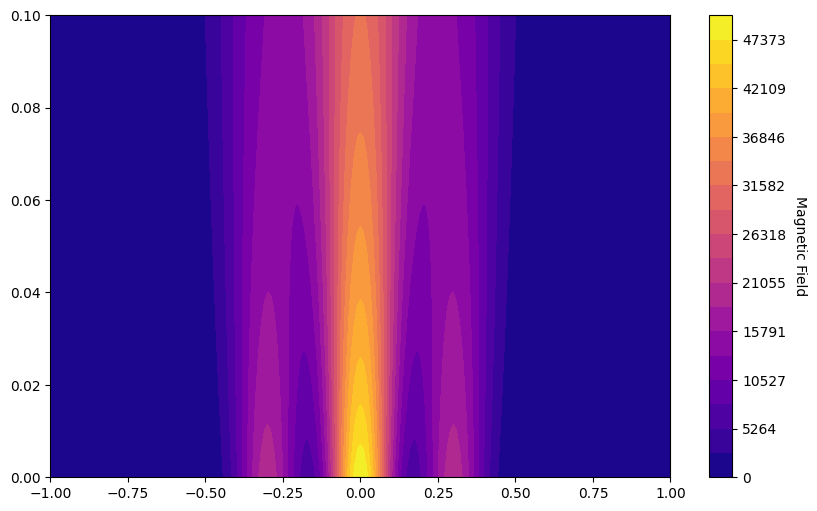

In [12]:
B_3_peak=calculate_B_i(eta,Nx,Nt,L,0.1,crank_nicolson_magnetic_diffusion,three_peak_initial)

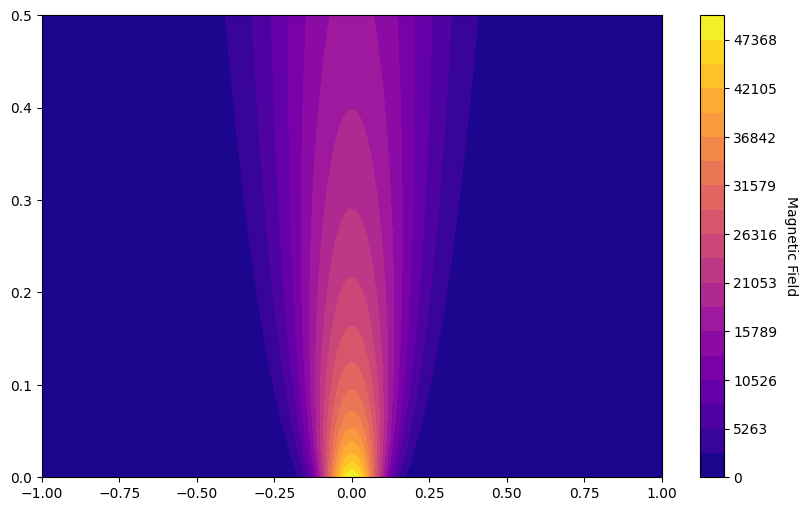

In [13]:
B_1_peak=calculate_B_i(eta,Nx,Nt,L,0.5,crank_nicolson_magnetic_diffusion,one_peak_initial)

**Different Boundary condition**

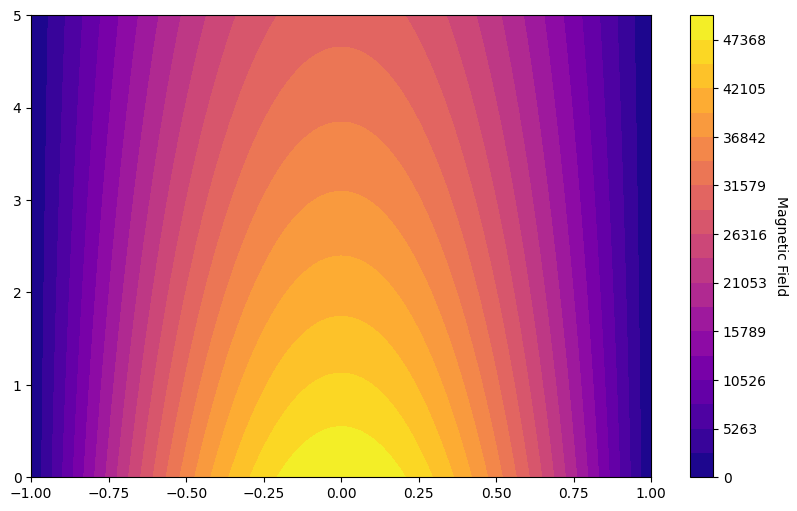

In [14]:
def boundary_conditions_pm(B):
    B[0] = 1000
    B[-1] = 1000
B_pmboundary=calculate_B_i(eta,Nx,Nt,L,5,crank_nicolson_magnetic_diffusion,initial_condition,boundary_conditions_pm)